In [2]:
# 라이브러리 불러오기
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from sklearn.model_selection import train_test_split
import torch

In [3]:
# 'class'를 'type'으로 매핑하는 딕셔너리 생성하기
class_to_type = {
    '협박 대화': 0,
    '갈취 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3,
    '일반 대화': 4
}

In [4]:
# 전처리 함수 정의하기
def preprocess_sentence(sentence): 
    # \n을 공백으로 바꾸기
    sentence = re.sub("\n", " ", sentence)
    
    # (ㄱ-ㅎ, ㅏ-ㅣ, ".", "?", "!", ",", ' ')를 제외한 모든 문자를 없애기
    sentence = re.sub("[^ㄱ-ㅣ가-힣.?!, ]", "", sentence)
    
    # 단어와 구두점(punctuation) 사이에 공백 추가하기
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    
    return sentence

In [5]:
PRETRAINED_MODEL = "gogamza/kobart-base-v2"

from transformers import BartTokenizerFast, PreTrainedTokenizerFast
# 각 conversation을 토큰화하여 새로운 열 'tokenized'에 저장
tokenizer=PreTrainedTokenizerFast.from_pretrained(PRETRAINED_MODEL)
# 단어사전 크기 20000으로 제한
VOCAB_SIZE=len(tokenizer.vocab)
# 대화 최대 길이 128으로 설정
MAX_LENGTH = 128

In [6]:
train_data_path ="/aiffel/aiffel/dlthon-minions/share/data/conversations.csv"
origin_data = pd.read_csv(train_data_path)

# 'class' 열을 기반으로 새로운 'type' 열 추가하기
origin_data['label'] = origin_data['class'].map(class_to_type)
origin_data.drop(['idx', 'class'], axis=1, inplace=True)


# 전처리 데이터 새로운 column에 저장하기
preprocessed = origin_data['conversation'].apply(preprocess_sentence).tolist()

In [7]:
tokenized = tokenizer(
    preprocessed, 
    max_length=MAX_LENGTH,
    padding='max_length',  # Pad to the max_length
    truncation=True,       # Truncate sequences to the max_length
    return_tensors='pt')

In [8]:
from torch.utils.data import Dataset, StackDataset

dataset = StackDataset(**dict(tokenized), 
                       labels=origin_data['label'].values)

import torch
from torch.utils.data import random_split, default_collate
generator2 = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset  = random_split(dataset, [0.8, 0.1, 0.1], generator=generator2)

In [9]:
print('Number of training data:', len(train_dataset))
print('Number of validation data:', len(val_dataset))
print('Number of test data:', len(test_dataset))


Number of training data: 3960
Number of validation data: 495
Number of test data: 495


In [10]:
# 데이터 로더 준비 함수 정의하기
from torch.utils.data import DataLoader

def prepare_dataloaders(train_dataset, val_dataset, test_dataset, batch_size, **kwargs):
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, **kwargs)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)
    
    return train_loader, val_loader, test_loader

In [11]:
import wandb
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, StackDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import numpy as np
from transformers import BartModel, BartConfig

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [12]:

# BART 분류기 클래스 정의하기
class BartForSequenceClassification(nn.Module):
    def __init__(self, num_labels):
        super(BartForSequenceClassification, self).__init__()
        self.num_labels = num_labels
        self.config = BartConfig.from_pretrained(PRETRAINED_MODEL, num_labels=num_labels)
        self.bart = BartModel.from_pretrained(PRETRAINED_MODEL, config=self.config)
        self.classifier = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(self.config.hidden_size, num_labels))
        
    def forward(self, *args, token_type_ids=None, labels=None, **kwargs, ): #input_ids, attention_mask=None, labels=None):
        outputs = self.bart(*args, **kwargs,)
        pooled_output = outputs[0][:, -1, :]  # 마지막 토큰의 출력 사용
#         pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        
        return loss, logits

In [16]:
!pip install torchviz graphviz --no-deps

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     |████████████████████████████████| 47 kB 935 kB/s             


In [17]:
from torchviz import make_dot

In [18]:
model = BartForSequenceClassification(5)

In [23]:
train_dataset[0:8]

{'input_ids': tensor([[14567, 14025, 21509,  ...,     3,     3,     3],
         [15746, 17966, 14098,  ...,     3,     3,     3],
         [15230, 11734, 14067,  ...,     3,     3,     3],
         ...,
         [14538, 19450, 10476,  ...,  1700, 14644, 14427],
         [18096, 10476, 14976,  ..., 17151, 11786, 15286],
         [14538,  9895, 12332,  ...,     3,     3,     3]]),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'labels': array([0, 1, 1, 1, 3, 2, 4, 3])}

In [33]:
# 설치한 폰트를 matplotlib에서 사용할 수 있도록 설정
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# 나눔 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# 폰트 매니저에 폰트 추가
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')  # 폰트 설정

In [32]:
import matplotlib.font_manager as fm

# Download and install a font that supports the required glyphs, if not already installed
# For example, Noto Sans CJK:
# You can download it from https://www.google.com/get/noto/ and install it on your system

# List all available fonts and check if the desired font is available
available_fonts = fm.findSystemFonts(fontpaths=None, fontext='ttf')
for font in available_fonts:
    if 'NanumGothic' in font:
        print(font)

/usr/share/fonts/truetype/nanum/NanumGothic.ttf
/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf


In [24]:
inputs = train_dataset[0:8]
inputs.pop('labels')
_, logit = model(**inputs)
# make_dot

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


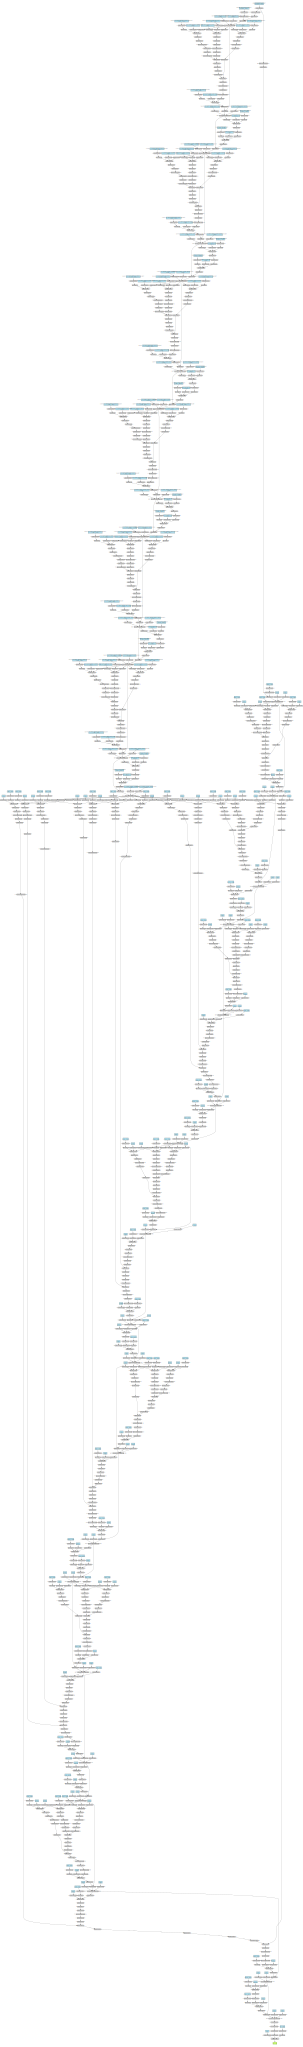

In [28]:
make_dot(logit, params = dict(model.bart.encoder.named_parameters()))